In [25]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [5]:
#generate url list
def getUrl(year):
    baseUrl = "https://www.basketball-reference.com/leagues/NBA_"
    months = ["october", "november", "december", "january", "february", "march", "april", "may", "june"]
    urlList = []
    year += 1
    for month in months:
        urlList.append(baseUrl + str(year) + "_games-" + month + ".html")
    return urlList

In [6]:
def compareScore(team1, score1, team2, score2):
    if score1 > score2:
        return (team1, team2)
    return (team2, team1)

In [18]:

#download html pages from urlList and parse the data
def collectAndParse(urlList):
    post = pd.DataFrame(columns=["date", "away", "awayScore", "home", "homeScore", "winTeam", "loseTeam"])
    reg = []
    try:
        for url in urlList:
            #print "working on " + url
            result = requests.get(url).text
            soup = BeautifulSoup(result, 'html.parser').find("table", {"id" : "schedule"}).find("tbody")
            for game in soup.find_all("tr"):
                gameDetail = {}

                gameDetail["date"] = game.find("th").get_text()

                if "Playoffs" in gameDetail["date"]:
                    reg = post
                    post = pd.DataFrame(columns=["date", "away", "awayScore", "home", "homeScore", "winTeam", "loseTeam"])
                    continue

                gameDetail["away"] = game.find("td", {"data-stat" : "visitor_team_name"}).get_text()
                gameDetail["awayScore"] = int(game.find("td", {"data-stat" : "visitor_pts"}).get_text())
                gameDetail["home"] = game.find("td", {"data-stat" : "home_team_name"}).get_text()
                gameDetail["homeScore"] = int(game.find("td", {"data-stat" : "home_pts"}).get_text())
                gameDetail["winTeam"], gameDetail["loseTeam"] = compareScore(gameDetail["away"], gameDetail["awayScore"], gameDetail["home"], gameDetail["homeScore"])
                data = pd.Series(gameDetail)
                post = post.append(data, ignore_index = True)
    except:
        if reg == []: reg = post
        return (reg, post)
    return (reg, post)

In [12]:
#Reference: https://github.com/sublee/trueskill#
import math
def cdf(x, mu=0, sigma=1):
    return 0.5 * erfc(-(x - mu) / (sigma * math.sqrt(2)))


def pdf(x, mu=0, sigma=1):
    return (1 / math.sqrt(2 * math.pi) * abs(sigma) *
            math.exp(-(((x - mu) / abs(sigma)) ** 2 / 2)))

def erfc(x):
    """Complementary error function (via `http://bit.ly/zOLqbc`_)"""
    z = abs(x)
    t = 1. / (1. + z / 2.)
    r = t * math.exp(-z * z - 1.26551223 + t * (1.00002368 + t * (
        0.37409196 + t * (0.09678418 + t * (-0.18628806 + t * (
            0.27886807 + t * (-1.13520398 + t * (1.48851587 + t * (
                -0.82215223 + t * 0.17087277
            )))
        )))
    )))
    return 2. - r if x < 0 else r

In [131]:
def TrueSkill(data, TrueSkillTable = 0, eps = 0):
    import copy
    #build Skill Table if not exists
    if type(TrueSkillTable) is not pd.DataFrame:
        TrueSkillTable = {}
        TrueSkillTable["team"] = data.away.unique()
        TrueSkillTable["mu"] = 1200.0
        TrueSkillTable["sigma"] = 1200.0/3
        TrueSkillTable["win"] = 0
        TrueSkillTable["lose"] = 0
        TrueSkillTable = pd.DataFrame(TrueSkillTable, columns = ["team", "mu", "sigma", "win", "lose"])
        beta = 1200.0/3/2
    else:
        teams = data.away.unique()
        TrueSkillTable = TrueSkillTable.loc[TrueSkillTable['team'].isin(teams)]
        TrueSkillTable["win"] = 0
        TrueSkillTable["lose"] = 0
        beta = sum(TrueSkillTable.sigma) / 16.0
        
    #build record mu overtime
    overtimeTable = {}
    overtimeTable["team"] = TrueSkillTable.team
    #overtimeTable["startingMu"] = copy.deepcopy(TrueSkillTable.mu)
    dateList = data.date.unique()

    for date in dateList:
        currentData = data[data.date == date]

        for result in currentData.iterrows():
            result = result[1]
            winTeam = result.winTeam
            loseTeam = result.loseTeam
            
            winMu = float(TrueSkillTable[TrueSkillTable.team == winTeam].mu.values[0])
            winSigma = float(TrueSkillTable[TrueSkillTable.team == winTeam].sigma.values[0])
            loseMu = float(TrueSkillTable[TrueSkillTable.team == loseTeam].mu.values[0])
            loseSigma = float(TrueSkillTable[TrueSkillTable.team == loseTeam].sigma.values[0])
            c = (2.0 * beta**2 + winSigma ** 2 + loseSigma ** 2)**(.5)
            t = (winMu - loseMu)/c
            v = pdf(t - eps)/cdf(t - eps)
            w = v * (v + t - eps)
            
            TrueSkillTable.loc[TrueSkillTable.team == winTeam, 'win'] += 1
            TrueSkillTable.loc[TrueSkillTable.team == loseTeam, 'lose'] += 1
            
            TrueSkillTable.loc[TrueSkillTable.team == winTeam, 'mu'] = winMu + (winSigma ** 2) / c * v
            TrueSkillTable.loc[TrueSkillTable.team == loseTeam, 'mu'] = loseMu - (loseSigma ** 2) / c * v
            TrueSkillTable.loc[TrueSkillTable.team == winTeam, 'sigma'] = (winSigma ** 2 * (1 - (winSigma ** 2) / (c ** 2) * w)) **(.5)
            TrueSkillTable.loc[TrueSkillTable.team == loseTeam, 'sigma'] = (loseSigma ** 2 * (1 - (loseSigma ** 2) / (c ** 2) * w)) **(.5)
        date = pd.to_datetime(date[5:], format = '%b %d, %Y')
        overtimeTable[date] = copy.deepcopy(TrueSkillTable.mu)
    overtimeTable = pd.DataFrame(overtimeTable)
    overtimeTable = overtimeTable.set_index('team')
    overtimeTable = overtimeTable.transpose()
    overtimeTable = overtimeTable.sort_index()
    overtimeTable = overtimeTable.sort_values(by=overtimeTable.index[-1], ascending=False, axis=1)
    TrueSkillTable = TrueSkillTable.sort_values(by = 'mu', ascending = False)
    return (TrueSkillTable, overtimeTable)

In [132]:
reg2015, post2015 =  collectAndParse(getUrl(2015))

ranking, timetable = TrueSkill(reg2015)

In [133]:
rankingPost, timetablePost = TrueSkill(post2015, TrueSkillTable= ranking)

/Users/pydu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/pydu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


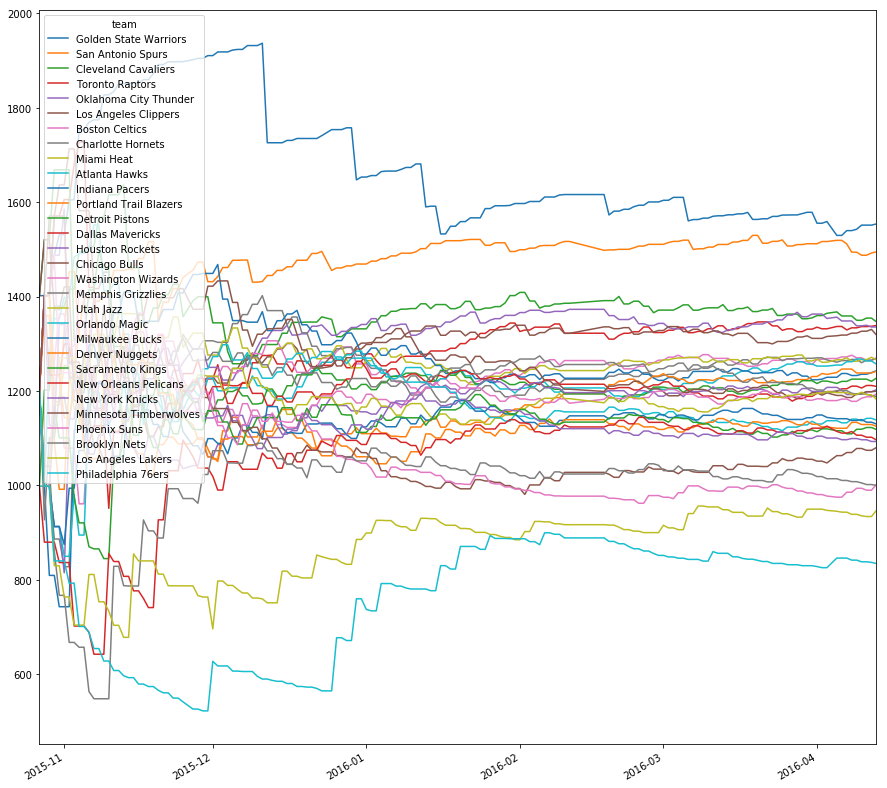

In [117]:
timetable[list(timetable.columns[0:31])].plot(figsize = (15,15))
plt.show()

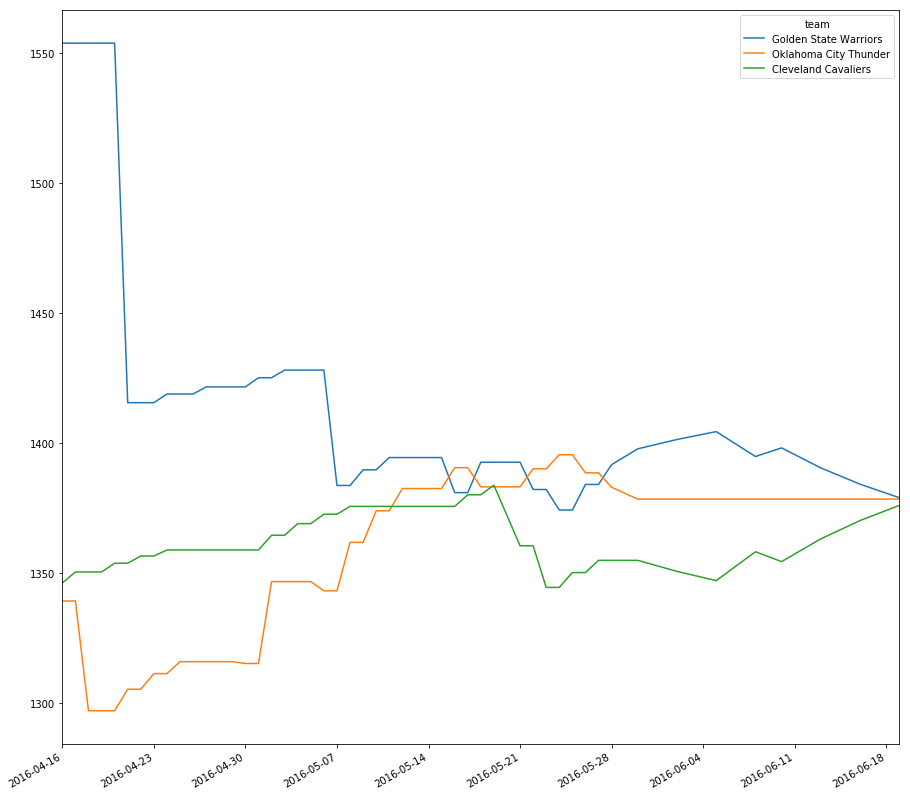

In [137]:
timetablePost[list(timetablePost.columns[0:3])].plot(figsize = (15,15))
plt.show()

In [135]:
timetablePost

team,Golden State Warriors,Oklahoma City Thunder,Cleveland Cavaliers,San Antonio Spurs,Portland Trail Blazers,Toronto Raptors,Miami Heat,Indiana Pacers,Houston Rockets,Atlanta Hawks,Charlotte Hornets,Los Angeles Clippers,Boston Celtics,Dallas Mavericks,Detroit Pistons,Memphis Grizzlies
2016-04-16 00:00:00,1553.880652,1339.247585,1346.169855,1494.911837,1241.866046,1302.969483,1265.771957,1276.537404,1202.632178,1276.136412,1269.016492,1318.547592,1251.404247,1205.939285,1227.462883,1188.321446
2016-04-17 00:00:00,1553.880652,1339.247585,1350.419553,1494.963838,1234.542053,1302.969483,1283.353165,1276.537404,1202.632178,1276.136412,1251.322146,1326.279505,1251.404247,1205.939285,1223.730121,1188.282121
2016-04-18 00:00:00,1553.904228,1297.016350,1350.419553,1494.963838,1234.542053,1314.595531,1283.353165,1265.382627,1202.619445,1276.136412,1251.322146,1326.279505,1251.404247,1245.702037,1223.730121,1188.282121
2016-04-19 00:00:00,1553.904228,1297.016350,1350.419553,1495.015363,1234.542053,1314.595531,1283.353165,1265.382627,1202.619445,1287.936538,1251.322146,1326.279505,1240.021422,1245.702037,1223.730121,1188.243139
2016-04-20 00:00:00,1553.904228,1297.016350,1353.791492,1495.015363,1229.228078,1314.595531,1294.212222,1265.382627,1202.619445,1287.936538,1240.406041,1331.855631,1240.021422,1245.702037,1220.740699,1188.243139
2016-04-21 00:00:00,1415.554689,1305.299720,1353.791492,1495.015363,1229.228078,1322.515414,1294.212222,1257.739804,1277.367736,1287.936538,1240.406041,1331.855631,1240.021422,1237.782915,1220.740699,1188.243139
2016-04-22 00:00:00,1415.554689,1305.299720,1356.553605,1495.066420,1229.228078,1322.515414,1294.212222,1257.739804,1277.367736,1267.593562,1240.406041,1331.855631,1259.744713,1237.782915,1218.273982,1188.204494
2016-04-23 00:00:00,1415.554689,1311.304117,1356.553605,1495.066420,1260.206101,1301.170006,1272.988941,1278.418661,1277.367736,1267.593562,1261.725564,1299.488570,1259.744713,1232.013258,1218.273982,1188.204494
2016-04-24 00:00:00,1418.884814,1311.304117,1358.872333,1495.117015,1260.206101,1301.170006,1272.988941,1278.418661,1275.126664,1254.786281,1261.725564,1299.488570,1272.229484,1232.013258,1216.190929,1188.166182
2016-04-25 00:00:00,1418.884814,1315.905594,1358.872333,1495.117015,1277.968589,1301.170006,1259.764259,1278.418661,1275.126664,1254.786281,1274.999320,1281.107442,1272.229484,1227.575554,1216.190929,1188.166182


In [136]:
rankingPost

,team,mu,sigma,win,lose
19,Golden State Warriors,1378.991725,19.356512,15,9
20,Oklahoma City Thunder,1378.455260,20.744036,11,7
1,Cleveland Cavaliers,1376.019287,20.384701,16,5
10,San Antonio Spurs,1371.195378,31.124593,6,4
21,Portland Trail Blazers,1309.792086,26.290452,5,6
17,Toronto Raptors,1306.709613,18.876865,10,10
18,Miami Heat,1278.539151,21.259899,7,7
14,Indiana Pacers,1276.321068,27.845708,3,4
27,Houston Rockets,1273.239787,37.854987,1,4
16,Atlanta Hawks,1267.174611,26.821993,4,6
